In [5]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [6]:
supply_data= pd.read_csv('C:/Users/Patron/Desktop/study/fin 850/SupplyData.csv')
supply_data['Date'] = pd.to_datetime(supply_data['Date'])
supply_data = supply_data.sort_values('Date')
supply_data['Supply'] = supply_data['Supply'].str.replace(',', '').astype(float)
supply_data.set_index('Date', inplace=True)  # Set as index

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1923 - mae: 0.3974 - val_loss: 0.0144 - val_mae: 0.0945
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0275 - mae: 0.1286 - val_loss: 0.0143 - val_mae: 0.0941
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0212 - mae: 0.1128 - val_loss: 0.0140 - val_mae: 0.0921
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0198 - mae: 0.1076 - val_loss: 0.0144 - val_mae: 0.0945
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0215 - mae: 0.1109 - val_loss: 0.0139 - val_mae: 0.0921
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0200 - mae: 0.1092 - val_loss: 0.0138 - val_mae: 0.0924
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0210 - mae: 0.1100 - val_loss: 0.0138 - val_mae: 0.0923
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0198 - mae: 0.1095 - val_loss: 0.0137 - val_mae: 0.0917
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0192 - mae

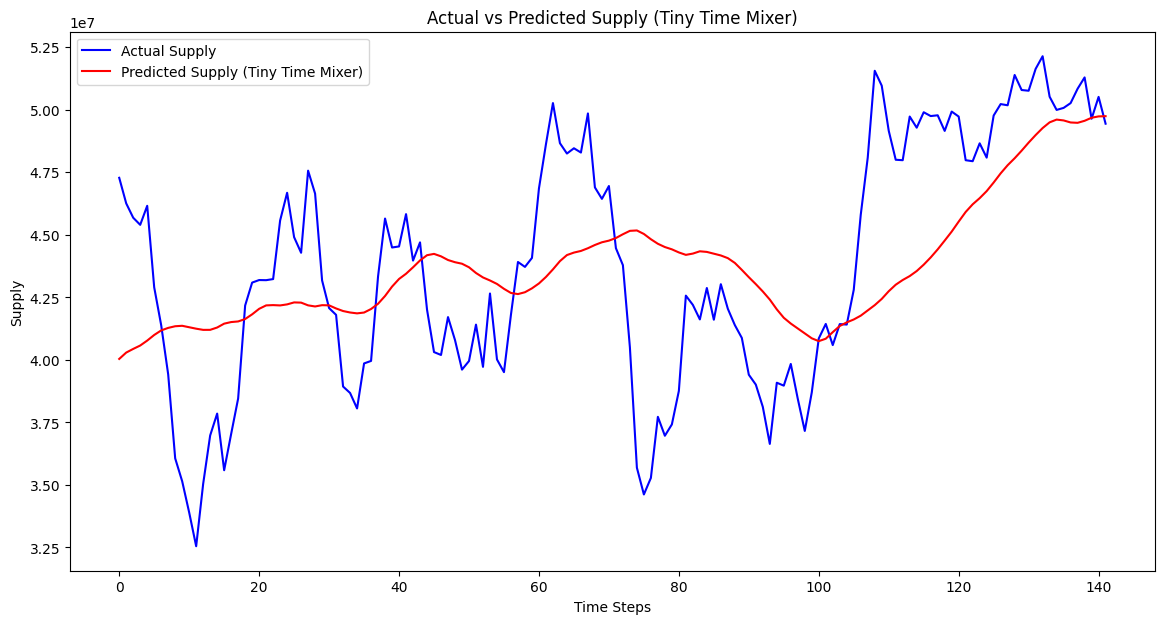

AttributeError: module 'keras._tf_keras.keras.metrics' has no attribute 'mean_absolute_error'

In [7]:
# Normalize the data for the model
scaler = MinMaxScaler()
supply_data['Supply_Scaled'] = scaler.fit_transform(supply_data[['Supply']])

# Define input-output windows for the time series model
def create_time_series_data(data, look_back=30):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 30
data = supply_data['Supply_Scaled'].values
# Ensure X is reshaped into a 3D array for time series model
X, y = create_time_series_data(data, look_back=look_back)
X = X.reshape((X.shape[0], X.shape[1], 1))  # Add a feature dimension

# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Build the model again
input_shape = (X_train.shape[1], X_train.shape[2])  # Correct shape with timesteps and features
ttm_model = build_tiny_time_mixer(input_shape)

# Train the model
history = ttm_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

# Make predictions
predictions = ttm_model.predict(X_test)

# Rescale predictions back to the original scale
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_rescaled = scaler.inverse_transform(predictions)

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled, label='Actual Supply', color='blue')
plt.plot(predictions_rescaled, label='Predicted Supply (Tiny Time Mixer)', color='red')
plt.title('Actual vs Predicted Supply (Tiny Time Mixer)')
plt.xlabel('Time Steps')
plt.ylabel('Supply')
plt.legend()
plt.show()

# Evaluate the model
mae = tf.keras.metrics.mean_absolute_error(y_test_rescaled, predictions_rescaled).numpy()
rmse = np.sqrt(tf.keras.metrics.mean_squared_error(y_test_rescaled, predictions_rescaled).numpy())
mae, rmse
